# Inspect the output of the nonstationary internal tide spectral parameters

cf `InternalTideClimate/NOTEBOOKS/analyse_suntans_ssh_harmonics.ipynb`

!pip install --user git+https://github.com/tide-itrh/speccy.git

In [68]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map
from tqdm import tqdm


In [70]:
import nonstat_itides_jax as nsjax

import nonstat_itides as nsit

In [3]:
# s3login = '/home/mrayson/code/s3.acacia.login'
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)

In [97]:
###
has_gamma = True
paramsfile = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_M2S2_vc.nc'
scenario = 'seasonaltides_meso_M2S2_vc'

# has_gamma = False
# gamma = 1.
# paramsfile = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_M2S2_gamma_1_0_vc.nc'
# scenario = 'seasonaltides_meso_M2S2_gamma_1_0_vc'


units='cm s$^{-1}$'
vmax=5.
varname='vc'



In [98]:
# f = S3Map("uwaoceanprocesses-suntans/"+paramsfile, s3=s3)
# ds_params = xr.open_dataset(f, engine='zarr', chunks={}, consolidated=False)

ds_params = xr.open_dataset(paramsfile, engine='h5netcdf')
# ds_params = xr.open_dataset(paramsfile, engine='zarr')

# These need filling in??
ds_params.suntans.xv=ds_params.xv.values
ds_params.suntans.yv=ds_params.yv.values

ds_params

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, params: 9, Nk: 80, time: 8761, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, params, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    data     (Nc, params) float64 ...
    dv       (Nc) float64 ...
    dz       (Nk) float64 ...
    nfaces   (Nc) int32 6 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6 6
    xp       (Np) float64 125.2 114.2 136.3 125.4 ... 117.0 117.0 117.1 117.1
    xv       (Nc) float64 109.0 109.1 109.1 109.2 ... 117.7 117.7 117.7 117.9
    yp       (Np) float64 -14.48 -22.48 -13.24 -14.54 ... -18.27 -18.27 -18.26
    yv       (Nc) float64 -19.4 -19.5 -19.61 -19.71 ... -13.1 -13.12 -13.07
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [99]:
datafile = ds_params['data'].attrs['input file']
datafile

'NWS_2km_GLORYS_2013_2014_vc_seasonaltides.zarr'

In [100]:
f = S3Map("uwaoceanprocesses-suntans/"+datafile, s3=s3)
ds_data = xr.open_dataset(f, engine='zarr', chunks={}, consolidated=False)

# These need filling in??
ds_data.suntans.xv=ds_data.xv.values
ds_data.suntans.yv=ds_data.yv.values

ds_data

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:              (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                          Np: 454016)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-0...
    z_r                  (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces               (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    vc_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    vc_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    xp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [101]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [102]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [103]:
# Regional plots
def plot_contours(ds):
    return ds.suntans.contourf(ds.dv, [200,1000], 
                           colors='k', 
                           linewidths=0.5, 
                           filled=False, colorbar=False)


def add_colorbar(ax, cc, vmin, vmax, titlestr):
    font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 12,
        }
    #cbaxes = inset_axes(ax, width="30%", height="3%", loc='lower right', bbox_to_anchor=(0, 0.1, 1, 1),
    #                       bbox_transform=ax.transAxes)
    #cb=plt.colorbar(cc, orientation='horizontal', cax=cbaxes)
    cb=plt.colorbar(cc, ax=ax, orientation='horizontal', shrink=0.3, pad=-0.1, )

    cb.set_ticks([vmin,vmax])
    cb.ax.set_title(titlestr, fontdict=font)

    return cb
        
def plot_params(ds_params, xlim, ylim, vmax, units, idx=[3,4,5,6]):
    fig = plt.figure(figsize=(11,8))

    ax1=plt.subplot(221, facecolor='0.5')
    _,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=idx[0])*100,
                                              colorbar=False, cmap='Reds', vmin=0,vmax=vmax)
    plot_contours(ds_params)
    #plt.title('Incoherent D2 amplitude [{}]'.format(units))
    add_colorbar(ax1, cc, 0, vmax, r'$\eta_{{M2}}$ [{}]'.format(units))
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_xticklabels([])
    #plt.xlabel('Longitude [$^{\circ}$E]')
    plt.ylabel('Latitude [$^{\circ}$N]')  
    
    ax2=plt.subplot(222, facecolor='0.5')
    _,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=idx[2]), 
                                              colorbar=False, cmap='viridis', vmin=0, vmax=15)
    plot_contours(ds_params)
    #plt.title('Incoherent D2 decay time scale [days]')
    add_colorbar(ax2, cc, 0, 15, r'$\tau_{{M2}}$ [{}]'.format('days'))

    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])

    ax3=plt.subplot(223, facecolor='0.5')
    _,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=idx[1])*100, 
                                              colorbar=False, cmap='Reds', vmin=0,vmax=vmax)
    plot_contours(ds_params)
    #plt.title('Incoherent D1 amplitude [{}]'.format(units))
    add_colorbar(ax3, cc, 0, vmax, r'$\eta_{{S2}}$ [{}]'.format(units))

    ax3.set_xlim(xlim)
    ax3.set_ylim(ylim)
    plt.xlabel('Longitude [$^{\circ}$E]')
    plt.ylabel('Latitude [$^{\circ}$N]')  

    ax4=plt.subplot(224, facecolor='0.5')
    _,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=idx[3]), 
                                              colorbar=False, cmap='viridis', vmin=0, vmax=15)
    plot_contours(ds_params)
    #plt.title('Incoherent D1 decay time scale [days]')
    add_colorbar(ax4, cc, 0, 15, r'$\tau_{{S2}}$ [{}]'.format('days'))

    ax4.set_xlim(xlim)
    ax4.set_ylim(ylim)
    ax4.set_yticklabels([])
    plt.xlabel('Longitude [$^{\circ}$E]')
    #plt.ylabel('Latitude [$^{\circ}$N]')  

    plt.tight_layout()
    return ax1, ax2, ax3, ax4


    
def plot_gamma(ds_params, xlim, ylim):
    fig = plt.figure(figsize=(10,4))

    ax1=plt.subplot(121, facecolor='0.5')
    _,_,cc,_ =ds_params.suntans.plotcelldata(ds_params['data'].isel(params=7), cmap='Blues', 
                                   vmin=1,vmax=2, colorbar=False)
    plot_contours(ds_params)
    add_colorbar(ax1, cc, 1, 2, r'$\gamma_{{M2}}$')
    #plt.title('M2 $\gamma$ parameter')
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    #ax1.set_xticklabels([])
    
    ax2=plt.subplot(122, facecolor='0.5')
    _,_,cc,_ =ds_params.suntans.plotcelldata(ds_params['data'].isel(params=8), cmap='Blues', 
                                   vmin=1,vmax=2,colorbar=False)
    plot_contours(ds_params)
    add_colorbar(ax2, cc, 1, 2, r'$\gamma_{{S2}}$')
    #plt.title('S2 $\gamma$ parameter')
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_yticklabels([])
    #ax2.set_xticklabels([])

# Regional plots

def plot_meso_params(ds_params, xlim, ylim, vmax, units, idx=[0,1,2]):
    fig = plt.figure(figsize=(10,4))

    ax1=plt.subplot(131, facecolor='0.5')
    _,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=idx[0])*100, 
                                   colorbar=False, cmap='Reds', vmin=0,vmax=25.)
    plot_contours(ds_params)
    add_colorbar(ax1, cc, 0, 25, r'$\eta_m$ [{}]'.format(units))
    #plt.title('Mesoscale amplitude [{}]'.format(units))
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    # ax1.set_xticklabels([])
    plt.xlabel('Longitude [$^{\circ}$E]')
    plt.ylabel('Latitude [$^{\circ}$N]')  
    
    ax2=plt.subplot(132, facecolor='0.5')
    _,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=idx[1]),
                                   colorbar=False, cmap='viridis', vmin=0, vmax=20)
    plot_contours(ds_params)
    add_colorbar(ax2, cc, 0, 20, r'$\tau_m$ [{}]'.format('days'))
    #plt.title('Mesoscale decay time scale [days]')
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_yticklabels([])
    plt.xlabel('Longitude [$^{\circ}$E]')
    #plt.ylabel('Latitude [$^{\circ}$N]')  

    ax3=plt.subplot(133, facecolor='0.5')
    _,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=idx[2]), 
                                   colorbar=False, cmap='Blues', vmin=0,vmax=2)
    plot_contours(ds_params)
    add_colorbar(ax3, cc, 0, 2, r'$\gamma_m$')
    #plt.title('Mesoscale gamma')
    ax3.set_xlim(xlim)
    ax3.set_ylim(ylim)
    ax3.set_yticklabels([])
    plt.xlabel('Longitude [$^{\circ}$E]')
    #plt.ylabel('Latitude [$^{\circ}$N]')  

    plt.tight_layout()
    return ax1, ax2, ax3




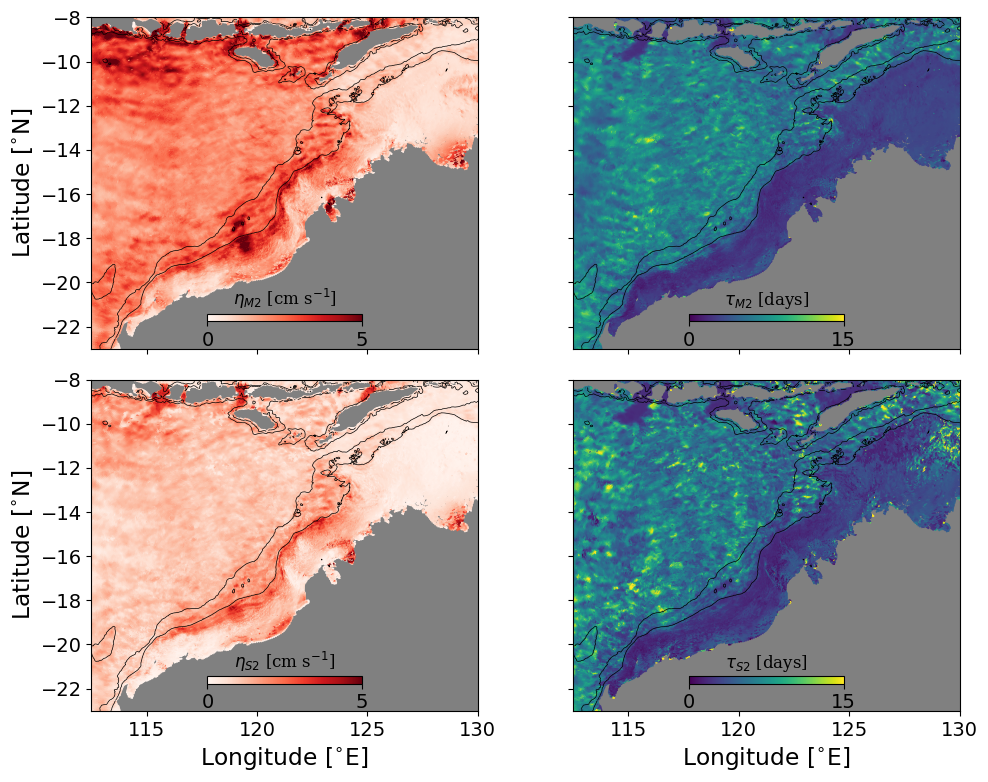

In [104]:
xlim = 112.5, 130
ylim = -23, -8
plot_params(ds_params, xlim, ylim, vmax, units)
plt.savefig('../FIGURES/suntans_ic_itide_params_{}.png'.format(scenario),dpi=150)

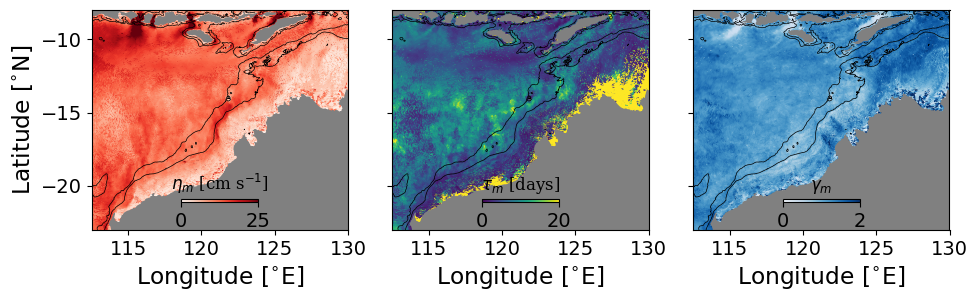

In [105]:
xlim = 112.5, 130
ylim = -23, -8
plot_meso_params(ds_params, xlim, ylim, vmax, units)
plt.savefig('../FIGURES/suntans_ic_itide_meso_params_{}.png'.format(scenario),dpi=150)

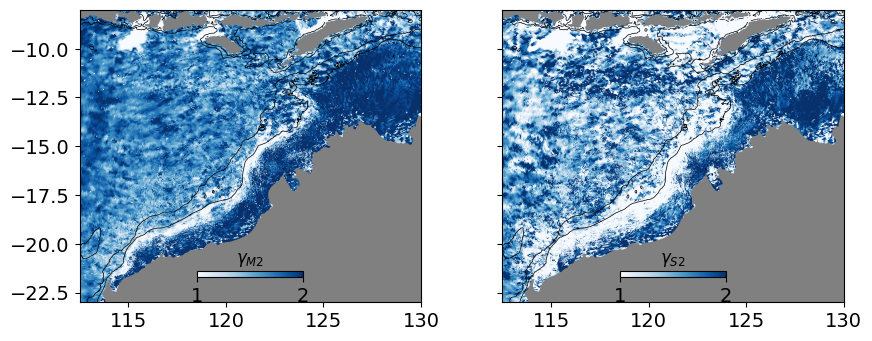

In [106]:
if has_gamma:
    plot_gamma(ds_params, xlim, ylim)
    plt.savefig('../FIGURES/suntans_ic_itide_gammaparams_{}.png'.format(scenario),dpi=150)

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 None)

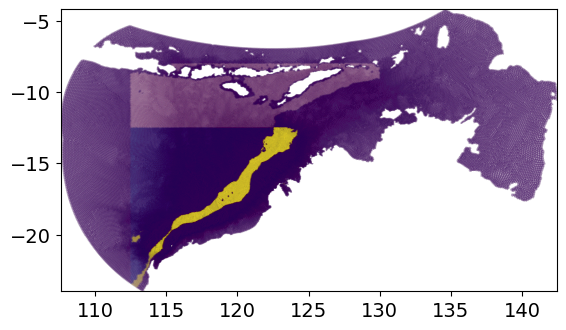

In [107]:
# Histograms of parameters in different regions

# Lower basin
regionA = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
    (ds_params.suntans.yv<-12.5) & (ds_params.dv>900)

# NWS
regionB = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
    (ds_params.suntans.yv<-12.5) & (ds_params.dv<900) & (ds_params.dv>200)

# Upper basin
regionC = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
    (ds_params.suntans.yv>-12.5) & (ds_params.suntans.yv<-8.0) & (ds_params.dv>900)

ds_params.suntans.plotcelldata(regionA, alpha=0.1, cmap='RdBu',colorbar=False)
ds_params.suntans.plotcelldata(regionC, alpha=0.1, cmap='gist_ncar',colorbar=False)
ds_params.suntans.plotcelldata(regionB, alpha=0.1, colorbar=False)



In [108]:
ds_params['data']

<xarray.DataArray 'data' (Nc: 225368, params: 9)>
[2028312 values with dtype=float64]
Dimensions without coordinates: Nc, params
Attributes:
    covariance function:  itide_M2S2_meso_gammaexp
    input file:           NWS_2km_GLORYS_2013_2014_vc_seasonaltides.zarr
    location:             face
    long_name:            Estimated covariance model parameters
    parameter names:      ['η_m', 'τ_m', 'γ_m', 'η_M2', 'η_S2', 'τ_M2', 'τ_S2...

In [109]:
def calc_stats(ds, param_idx, region):
    data = ds['data'].isel(params=param_idx).values[region]
    #ff = [np.nanmean(data), np.nanstd(data)]
    ff = [np.nanpercentile(data,50), np.nanpercentile(data,90)]
    return f"{ff[0]:3.2f} ({ff[1]:3.2f})"

nc = ds_params.dims['params']
mystrA = 'A '
for ii in range(nc):
    mystrA += '| ' + calc_stats(ds_params, ii, regionA) 

mystrB = 'B '
for ii in range(nc):
    mystrB += '| ' + calc_stats(ds_params, ii, regionB) 

mystrC = 'C '
for ii in range(nc):
    mystrC += '| ' + calc_stats(ds_params, ii, regionC) 

print(ds_params['data'].attrs['parameter names'])
print(mystrA)
print(mystrB)
print(mystrC)

['η_m', 'τ_m', 'γ_m', 'η_M2', 'η_S2', 'τ_M2', 'τ_S2', 'γ_M2', 'γ_S2']
A | 0.12 (0.15)| 8.66 (11.87)| 1.16 (1.33)| 0.02 (0.03)| 0.01 (0.01)| 6.66 (8.63)| 6.05 (8.94)| 1.61 (1.86)| 1.43 (1.99)
B | 0.12 (0.15)| 7.09 (11.55)| 0.98 (1.18)| 0.03 (0.03)| 0.02 (0.02)| 5.70 (7.85)| 4.57 (7.55)| 1.47 (1.87)| 1.09 (1.81)
C | 0.13 (0.18)| 4.83 (8.64)| 1.27 (1.48)| 0.02 (0.03)| 0.01 (0.02)| 6.13 (8.21)| 5.50 (8.77)| 1.61 (1.90)| 1.50 (2.27)


Table Caption: Median values and 90th percentile shown in brackets

region | η_m | 'τ_m' | 'γ_m' | 'η_M2' | 'η_S2' | 'τ_M2' | 'τ_S2' | 'γ_M2'| 'γ_S2'
-------|-----|-------|-------|--------|--------|--------|--------|-------|-------
A | 0.12 (0.15)| 8.66 (11.87)| 1.16 (1.33)| 0.02 (0.03)| 0.01 (0.01)| 6.66 (8.63)| 6.05 (8.94)| 1.61 (1.86)| 1.43 (1.99)
B | 0.12 (0.15)| 7.09 (11.55)| 0.98 (1.18)| 0.03 (0.03)| 0.02 (0.02)| 5.70 (7.85)| 4.57 (7.55)| 1.47 (1.87)| 1.09 (1.81)
C | 0.13 (0.18)| 4.83 (8.64)| 1.27 (1.48)| 0.02 (0.03)| 0.01 (0.02)| 6.13 (8.21)| 5.50 (8.77)| 1.61 (1.90)| 1.50 (2.27)

---

region | η_m | 'τ_m' | 'γ_m' | 'η_M2' | 'η_S2' | 'τ_M2' | 'τ_S2' | 
-------|-----|-------|-------|--------|--------|--------|--------|
A | 0.13 (0.16)| 8.91 (11.39)| 1.29 (1.56)| 0.02 (0.03)| 0.01 (0.01)| 11.36 (16.12)| 9.75 (14.19)
B | 0.13 (0.16)| 9.40 (11.18)| 1.04 (1.24)| 0.03 (0.03)| 0.01 (0.02)| 7.41 (11.11)| 5.96 (10.24)
C | 0.14 (0.18)| 4.54 (9.09)| 1.39 (1.66)| 0.02 (0.03)| 0.01 (0.02)| 9.81 (14.64)| 9.42 (14.14)

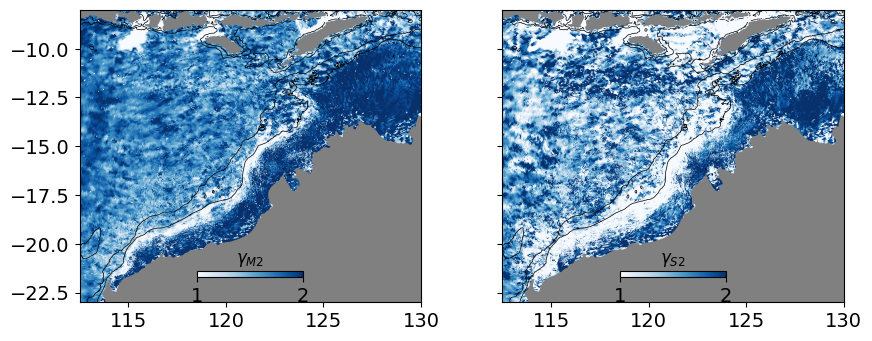

In [117]:
if has_gamma:
    xlim = 112.5, 130
    ylim = -23, -8
    plot_gamma(ds_params, xlim, ylim)
    plt.savefig('../FIGURES/suntans_ic_itide_gammaparams_{}.png'.format(scenario),dpi=150)

In [111]:
# Plot integral timescales
def integral_timescale(covfunc, covparams, tmax=500, N=1000):
    t = np.linspace(0, tmax, N) # days

    acf = covfunc(t, t[0], covparams)
    
    return 1./covparams[0]**2 * np.trapz(acf, t)

In [112]:
tau_M = ds_params['data'].isel(params=1).values
gamma_M = ds_params['data'].isel(params=2).values
tau_M2 = ds_params['data'].isel(params=5).values
tau_S2 = ds_params['data'].isel(params=6).values
if has_gamma:
    gamma_M2 = ds_params['data'].isel(params=7).values
    gamma_S2 = ds_params['data'].isel(params=8).values
else:
    gamma_M2 = gamma*np.ones_like(tau_M)
    gamma_S2 = gamma*np.ones_like(tau_M)

T_M = np.zeros_like(tau_M)
T_M2 = np.zeros_like(tau_M)
T_S2 = np.zeros_like(tau_M)

acf = nsjax.gamma_exp_1d

for ii in tqdm(range(T_M.shape[0])):
    T_M[ii] =  integral_timescale(acf, (1, tau_M[ii], gamma_M[ii]), tmax=500, N=1000)
    T_M2[ii] =  integral_timescale(acf, (1, tau_M2[ii], gamma_M2[ii]), tmax=500, N=1000)
    T_S2[ii] =  integral_timescale(acf, (1, tau_S2[ii], gamma_S2[ii]), tmax=500, N=1000)

100%|██████████| 225368/225368 [02:43<00:00, 1380.09it/s]


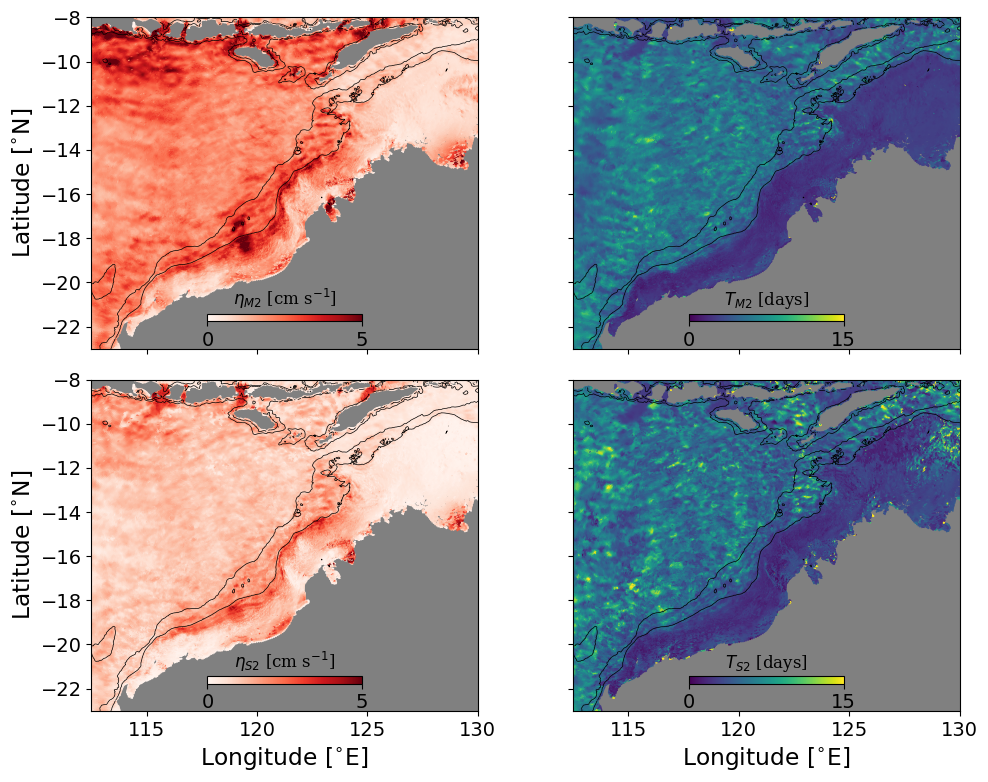

In [118]:
xlim = 112.5, 130
ylim = -23, -8

fig = plt.figure(figsize=(11,8))

ax1=plt.subplot(221, facecolor='0.5')
_,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=3)*100,
                                          colorbar=False, cmap='Reds', vmin=0,vmax=vmax)
plot_contours(ds_params)
#plt.title('Incoherent D2 amplitude [{}]'.format(units))
add_colorbar(ax1, cc, 0, vmax, r'$\eta_{{M2}}$ [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xticklabels([])
#plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

ax2=plt.subplot(222, facecolor='0.5')
_,_,cc,_ = ds_params.suntans.plotcelldata(T_M2, 
                                          colorbar=False, cmap='viridis', vmin=0, vmax=15)
plot_contours(ds_params)
#plt.title('Incoherent D2 decay time scale [days]')
add_colorbar(ax2, cc, 0, 15, r'$T_{{M2}}$ [{}]'.format('days'))

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

ax3=plt.subplot(223, facecolor='0.5')
_,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=4)*100, 
                                          colorbar=False, cmap='Reds', vmin=0,vmax=vmax)
plot_contours(ds_params)
#plt.title('Incoherent D1 amplitude [{}]'.format(units))
add_colorbar(ax3, cc, 0, vmax, r'$\eta_{{S2}}$ [{}]'.format(units))

ax3.set_xlim(xlim)
ax3.set_ylim(ylim)
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

ax4=plt.subplot(224, facecolor='0.5')
_,_,cc,_ = ds_params.suntans.plotcelldata(T_S2, 
                                          colorbar=False, cmap='viridis', vmin=0, vmax=15)
plot_contours(ds_params)
#plt.title('Incoherent D1 decay time scale [days]')
add_colorbar(ax4, cc, 0, 15, r'$T_{{S2}}$ [{}]'.format('days'))

ax4.set_xlim(xlim)
ax4.set_ylim(ylim)
ax4.set_yticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
#plt.ylabel('Latitude [$^{\circ}$N]')  

plt.tight_layout()

plt.savefig('../FIGURES/suntans_ic_itide_Tintegral_{}.png'.format(scenario),dpi=150)

In [114]:
ds_time = xr.Dataset(
    {'T_M':xr.DataArray(T_M, dims=('Nc')),
    'T_M2':xr.DataArray(T_M2, dims=('Nc')),
    'T_S2':xr.DataArray(T_S2, dims=('Nc')),
    }
)


In [115]:
def calc_stats2(data, region):
    data = data[region]
    #data = ds['data'].isel(params=param_idx).values[region]
    #ff = [np.nanmean(data), np.nanstd(data)]
    ff = [np.nanpercentile(data,50), np.nanpercentile(data,90)]
    return f"{ff[0]:3.2f} ({ff[1]:3.2f})"
    
nc = 3
mystrA = 'A '
for var_name, values in ds_time.items():
    mystrA += '| ' + calc_stats2(values, regionA) 

mystrB = 'B '
for var_name, values in ds_time.items():
    mystrB += '| ' + calc_stats2(values, regionB) 

mystrC = 'C '
for var_name, values in ds_time.items():
    mystrC += '| ' + calc_stats2(values, regionC) 
    print(var_name)
print(mystrA)
print(mystrB)
print(mystrC)

T_M
T_M2
T_S2
A | 8.22 (11.57)| 5.99 (7.81)| 5.61 (8.23)
B | 7.23 (12.45)| 5.21 (7.21)| 4.53 (7.30)
C | 4.53 (8.58)| 5.52 (7.43)| 5.15 (8.10)



Table: gamma = 1.

region | T_m | T_M2 | T_S2
-------|-----|------|------
A | 8.33 (10.86)| 11.37 (16.12)| 9.75 (14.19)
B | 9.32 (11.59)| 7.41 (11.11)| 5.96 (10.24)
C | 4.19 (8.98)| 9.81 (14.64)| 9.42 (14.14)

Table: gamma = variable

region | T_m | T_M2 | T_S2
-------|-----|------|------
A | 8.22 (11.57)| 5.99 (7.81)| 5.61 (8.23)
B | 7.23 (12.45)| 5.21 (7.21)| 4.53 (7.30)
C | 4.53 (8.58)| 5.52 (7.43)| 5.15 (8.10)



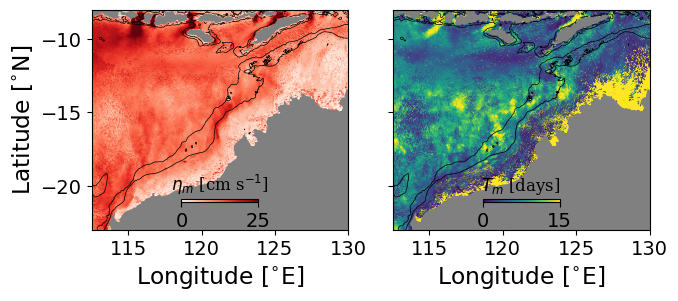

In [119]:
xlim = 112.5, 130
ylim = -23, -8

fig = plt.figure(figsize=(7,4))

ax1=plt.subplot(121, facecolor='0.5')
_,_,cc,_ = ds_params.suntans.plotcelldata(ds_params['data'].isel(params=0)*100, 
                               colorbar=False, cmap='Reds', vmin=0,vmax=25.)
plot_contours(ds_params)
add_colorbar(ax1, cc, 0, 25, r'$\eta_m$ [{}]'.format(units))
#plt.title('Mesoscale amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
# ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

ax2=plt.subplot(122, facecolor='0.5')
_,_,cc,_ = ds_params.suntans.plotcelldata(T_M,
                               colorbar=False, cmap='viridis', vmin=0, vmax=15)
plot_contours(ds_params)
add_colorbar(ax2, cc, 0, 15, r'$T_m$ [{}]'.format('days'))
#plt.title('Mesoscale decay time scale [days]')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_yticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
#plt.ylabel('Latitude [$^{\circ}$N]')  

plt.tight_layout()

plt.savefig('../FIGURES/suntans_ic_itide_meso_Tintegral_{}.png'.format(scenario),dpi=150)
